<a href="https://colab.research.google.com/github/veeragowri/plant-village/blob/main/plant_village.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

filtered_path = '/content/filtered_plant_disease'
os.makedirs(filtered_path, exist_ok=True)


In [4]:
import os

dataset_path = '/content/drive/MyDrive/PlantVillage'
print(os.listdir(dataset_path))


['Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Potato___healthy', 'Tomato_Late_blight', 'Tomato_Bacterial_spot', 'PlantVillage', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', 'Tomato_healthy', 'Potato___Early_blight']


In [5]:
import os
import shutil

source_dir = '/content/drive/MyDrive/PlantVillage'
filtered_path = '/content/filtered_plant_disease'

selected_classes = [
    'Tomato_healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Late_blight',
    'Potato___healthy',
    'Potato___Late_blight'
]

os.makedirs(filtered_path, exist_ok=True)

for class_name in selected_classes:
    src = os.path.join(source_dir, class_name)
    dst = os.path.join(filtered_path, class_name)

    if not os.path.exists(dst):  # ✅ Only copy if not already exists
        if os.path.exists(src):
            shutil.copytree(src, dst)
            print(f"✅ Copied: {class_name}")
        else:
            print(f"❌ Not found: {src}")
    else:
        print(f"⏩ Skipped (already exists): {class_name}")


✅ Copied: Tomato_healthy
✅ Copied: Tomato_Bacterial_spot
✅ Copied: Tomato_Late_blight
✅ Copied: Potato___healthy
✅ Copied: Potato___Late_blight


In [6]:
!pip install tensorflow opencv-python matplotlib streamlit

Found 6863 files belonging to 5 classes.
Using 5491 files for training.
Found 6863 files belonging to 5 classes.
Using 1372 files for validation.
Class names: ['Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_healthy']
Number of classes: 5
(32, 128, 128, 3)
(32,)


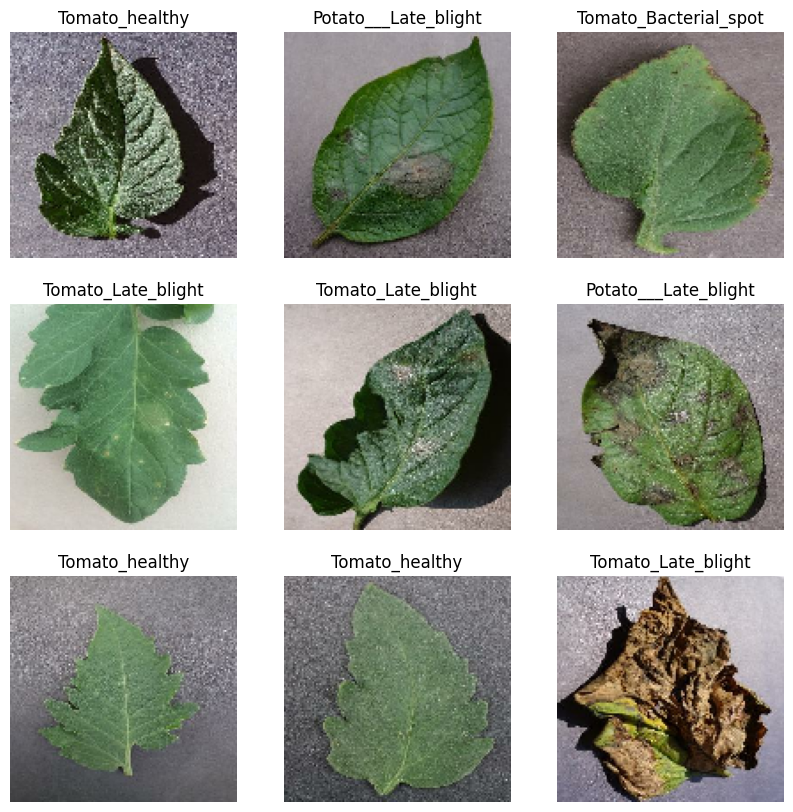

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define image dimensions and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Load the dataset using image_dataset_from_directory
# This function automatically resizes, shuffles, and batches images.
# It also infers labels from subdirectory names.
train_ds = tf.keras.utils.image_dataset_from_directory(
    filtered_path,
    labels='inferred',
    label_mode='int', # Use 'int' for integer labels (sparse_categorical_crossentropy)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2, # 20% for validation
    subset='training',
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    filtered_path,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds_normalized = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_normalized = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_normalized.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_normalized.cache().prefetch(buffer_size=AUTOTUNE)

# Verify a batch of data
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape) # (batch_size, IMG_HEIGHT, IMG_WIDTH, 3)
    print(label_batch.shape) # (batch_size,)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()

In [8]:
from tensorflow.keras import layers, models

# Define the CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Add dropout for regularization
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False because we have softmax
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
EPOCHS = 15 # You can increase this for better accuracy, but be mindful of training time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5422 - loss: 1.1280 - val_accuracy: 0.8710 - val_loss: 0.3492
Epoch 2/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 180s 992ms/step - accuracy: 0.8386 - loss: 0.4302 - val_accuracy: 0.8972 - val_loss: 0.3031
Epoch 3/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 202s 994ms/step - accuracy: 0.9049 - loss: 0.2721 - val_accuracy: 0.9096 - val_loss: 0.2648
Epoch 4/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 198s 969ms/step - accuracy: 0.9172 - loss: 0.2206 - val_accuracy: 0.9235 - val_loss: 0.2173
Epoch 5/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 166s 968ms/step - accuracy: 0.9210 - loss: 0.2210 - val_accuracy: 0.9490 - val_loss: 0.1865
Epoch 6/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 167s 969ms/step - accuracy: 0.9437 - loss: 0.1556 - val_accuracy: 0.9577 - val_loss: 0.1731
Epoch 7/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 167s 969ms/step - accuracy: 0.9532 - loss: 0.1235 - val_accuracy: 0.9359 - val_loss: 0.2310
Epoch 8/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9525 - loss:

43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.9434 - loss: 0.2813
Validation Loss: 0.2610
Validation Accuracy: 0.9453


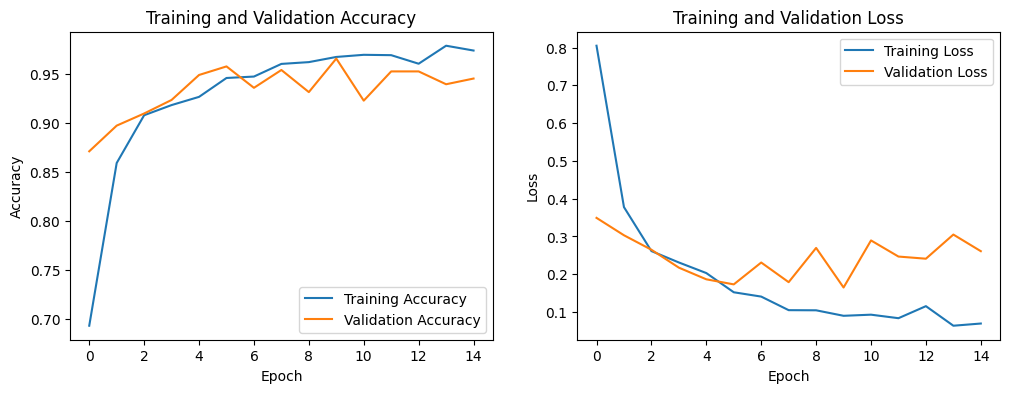

Model saved to /content/drive/MyDrive/plant_disease_model.keras


In [9]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Save the trained model
model_save_path = '/content/drive/MyDrive/plant_disease_model.keras' # Save to Google Drive
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

In [10]:
%%writefile requirements.txt
tensorflow
opencv-python
matplotlib
numpy
pandas
streamlit


Writing requirements.txt


In [11]:
!pip install -r requirements.txt


In [12]:
# Install Streamlit
!pip install streamlit -q

# Install localtunnel to expose the Streamlit app publicly
!npm install localtunnel -g

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
changed 22 packages in 3s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

In [31]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from keras.models import load_model
from PIL import Image
import numpy as np
import cv2
import os

# Define the image size used during training
IMG_SIZE = (128, 128)

# Load the trained model
@st.cache_resource
def load_my_model():
    # Adjust path if you saved it differently, or load from /content/ if not using Drive
    model_path = 'plant_disease_model.keras'
    # In Colab, if saving to Drive, ensure it's mounted and path is correct.
    # For simplicity in deployment, copy model to same dir as app.py if needed.
    return load_model(model_path)

# Load model (make sure the .h5 file is in the same directory or accessible path)
# If you saved it to Google Drive, you'll need to copy it to /content/ for Streamlit to find it
# or adjust the path here. For this Colab setup, assume it's in the same /content/ directory
# after being copied from Drive or downloaded.
if not os.path.exists('plant_disease_model.keras'):
    st.error("Model file 'plant_disease_model.keras' not found. Please ensure it's in the same directory as app.py or update the path.")
    st.stop()

model = load_my_model()

# Class names (IMPORTANT: MUST be in the same order as trained)
# Ensure these match the order from train_ds.class_names
class_names = ['Potato_Late_blight', 'Potato_healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy']
# Replace with your actual `class_names` from the training step.
# You can print `train_ds.class_names` in the training section to confirm.

st.title("🌿 Plant Disease Detector")
st.write("Upload a leaf image to predict its disease status!")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Leaf Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Pre-process the image
    img_array = np.array(image)
    # Convert RGB (Pillow) to BGR (OpenCV) if necessary for OpenCV processing
    # Streamlit uses PIL, which is RGB. OpenCV uses BGR.
    # If your model was trained with images loaded by OpenCV directly, they were BGR.
    # If your model was trained with tf.keras.utils.image_dataset_from_directory,
    # it typically loads as RGB. So, a direct conversion to RGB np array is fine.
    # Ensure consistency with your training data loading.
    # For `image_dataset_from_directory`, it loads as RGB, so no BGR conversion needed.

    # Resize the image
    img_resized = cv2.resize(img_array, IMG_SIZE)

    # Normalize the image
    img_normalized = img_resized / 255.0

    # Add batch dimension
    img_input = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    predictions = model.predict(img_input)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    predicted_class_name = class_names[predicted_class_index]

    st.success(f"**Predicted Disease:** {predicted_class_name}")
    st.write(f"**Confidence:** {confidence:.2f}%")

    st.markdown("---")
    st.subheader("All Class Probabilities:")
    for i, prob in enumerate(predictions[0]):
        st.write(f"- {class_names[i]}: {prob*100:.2f}%")

Overwriting app.py


In [32]:
!pip install pyngrok -q # Python wrapper for ngrok

In [33]:
from pyngrok import ngrok

# Replace 'YOUR_AUTHTOKEN' with the token you copied from ngrok.com
ngrok.set_auth_token("2yxqElYSCozfTr5KfQ1944QmKCL_5h9bakCo5Z5jZheDGCHn4")

In [34]:
import os
import threading
import time
import subprocess # Import subprocess

# Define the port Streamlit runs on
STREAMLIT_PORT = 8501

# Function to start Streamlit in a separate thread/process
def start_streamlit():
    # Use subprocess.Popen for better control and non-blocking execution
    process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", str(STREAMLIT_PORT), "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"])
    # Wait a bit for Streamlit to start up
    time.sleep(5)
    return process

# Start Streamlit in the background
print(f"Starting Streamlit on port {STREAMLIT_PORT}...")
streamlit_process = start_streamlit() # Keep a reference to the process

# Start ngrok tunnel
print("Starting ngrok tunnel...")
try:
    public_url = ngrok.connect(STREAMLIT_PORT)
    print(f"Your Streamlit app is live at: {public_url}")
except Exception as e:
    print(f"Error starting ngrok tunnel: {e}")
    print("This might be due to a disconnected ngrok client or rate limits.")
    print("Please check your ngrok auth token and try again.")

# You might want to add a loop here to keep the Colab session alive
# and prevent the notebook from automatically shutting down if no other activity
# while True:
#     time.sleep(600) # Sleep for 10 minutes

Starting Streamlit on port 8501...
Starting ngrok tunnel...
Your Streamlit app is live at: NgrokTunnel: "https://caa4-35-229-230-224.ngrok-free.app" -> "http://localhost:8501"
